In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m,1)
y = 1 + 0.5*X + np.random.randn(m,1)/1.5
X_new = np.linspace(0,3,100).reshape(100,1)

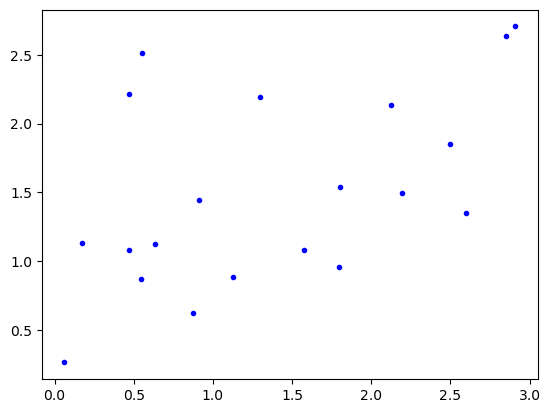

In [3]:
plt.plot(X,y,'b.')

Redge Regression

In [2]:
from sklearn.linear_model import Ridge, SGDRegressor, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

In [6]:
ridge_reg = Ridge(alpha=1, solver='cholesky', random_state=42)
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [9]:
ridge_reg = Ridge(alpha=1, solver='saga', random_state=42)
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[1.55071333]])

In [50]:
def plot_ridge(model_class, alpha, polynomial = False, **model_kargs):
    for a, style in zip(alpha, ('g-', 'b-', 'r-')):
        model = model_class(a, **model_kargs) if a > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                ('poly_reg', PolynomialFeatures(degree=10, include_bias=False)),
                ('Standard_Scaler', StandardScaler()),
                ('lin_reg', model),
            ])
        model.fit(X, y)
        prediction = model.predict(X_new)
        plt.plot(X,y,'b.')
        plt.plot(X_new, prediction, style, label = f'alpha = {a}')
        plt.legend()

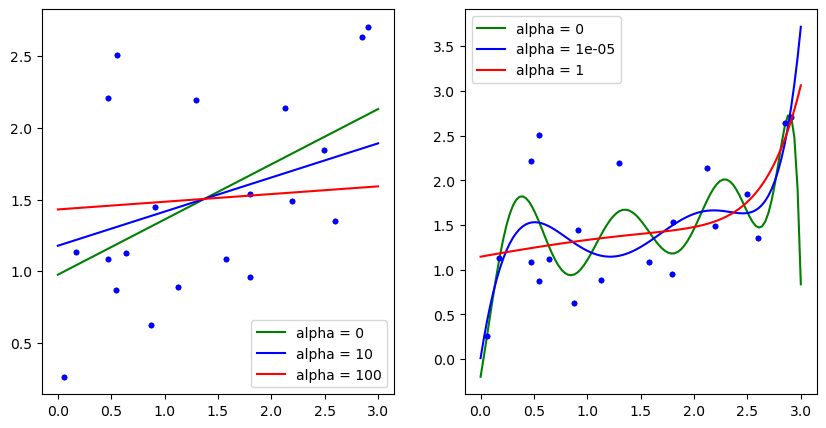

In [51]:
plt.figure(figsize=(10,5))
plt.subplot(121); plot_ridge(Ridge, (0,10,100), polynomial=False, random_state = 42)
plt.subplot(122); plot_ridge(Ridge, (0,10**-5,1), polynomial=True, random_state = 42)

Ridge with SGD

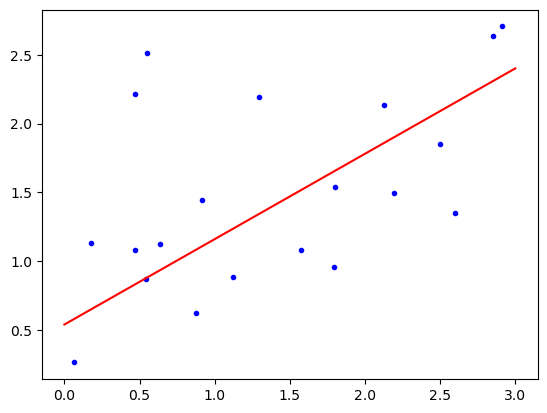

In [30]:
sgd_reg = SGDRegressor(penalty='l2', max_iter=100, tol=1e-3, random_state=42)
sgd_reg.fit(X,y.ravel())
plt.plot(X,y,'b.')
plt.plot(X_new,sgd_reg.predict(X_new),'r-')
plt.show()

Lasso Regression

In [38]:
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')

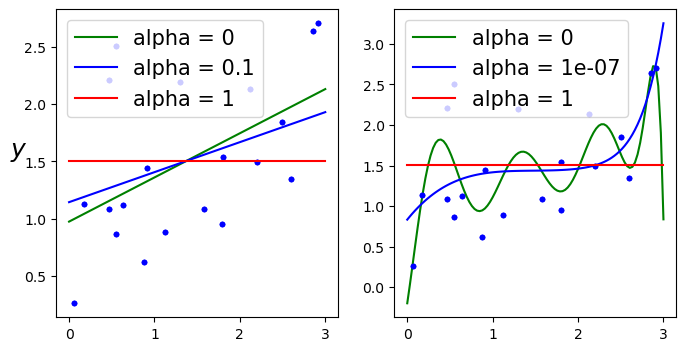

In [52]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_ridge(Lasso, alpha=(0, 0.1, 1), polynomial=False, random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=15)
plt.subplot(122)
plot_ridge(Lasso, alpha=(0, 10**-7, 1), polynomial=True,  random_state=42)
plt.legend(loc="upper left", fontsize=15)

plt.show()

In [53]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

Elastic Net

In [54]:
from sklearn.linear_model import ElasticNet

In [55]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

implementation of Early stopping algorithm

In [20]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [21]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

In [22]:
poly_scaler = Pipeline([
    ('poly_reg', PolynomialFeatures(degree=10, include_bias=False)),
    ('std_scaler', StandardScaler()),
])

In [23]:
X_train_prep = poly_scaler.fit_transform(X_train)
X_valid_prep = poly_scaler.transform(X_valid)

In [24]:
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)

In [25]:
n_epoch = 500
best_valid_rmse = float("inf")
train_errors, val_errors = [], [] 

for epoch in range(n_epoch):
    sgd_reg.partial_fit(X_train_prep,y_train)
    y_val_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid,y_val_predict, squared=False)
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)

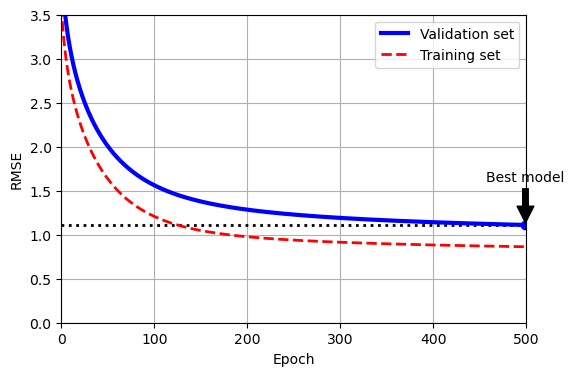

In [28]:
best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epoch], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epoch, 0, 3.5])
plt.grid()
plt.show()